In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class NbarCov:
    
    def __init__(self, c, n):
        """ read covariance matrix """
        from glob import glob
        
        path = '/home/mehdi/data/eboss/mocks/1.0/measurements/nnbar/'
        nnbar_null = glob(f'{path}nnbar_{c}_knownsystot_mainhighz_512_v7_0_*_main_{n}.npy')
        self.nmocks = len(nnbar_null)
        print(f'nmocks: {self.nmocks}')

        err_tot = []
        for j, fn in enumerate(nnbar_null):
            d = np.load(fn, allow_pickle=True)

            err_j = []
            for i, di in enumerate(d):
                err_j.append(di['nnbar'] - 1.0)
            err_tot.append(err_j)            
        self.err_tot = np.cov(np.array(err_tot).reshape(self.nmocks, -1), 
                              rowvar=False)

    def get_invcov(self, start, end, return_covmax=False):
        # https://arxiv.org/pdf/astro-ph/0608064.pdf
        err_tot_ = self.err_tot[start:end, start:end]
        
        nbins = err_tot_.shape[0]        
        print(f'nbins: {nbins}')

        hartlop_factor = (self.nmocks - 1.) / (self.nmocks - nbins - 2.)
        covmax = hartlop_factor * err_tot_
        if return_covmax:
            return np.linalg.inv(covmax), covmax
        else:
            return np.linalg.inv(covmax)

In [16]:
def plot_overdensity(fig_path, sample='main'):    
    # maps_eboss_v7p2 = [
    #     'star_density', 'ebv', 'loghi',
    #     'sky_g', 'sky_r', 'sky_i', 'sky_z',
    #     'depth_g_minus_ebv','depth_r_minus_ebv', 
    #     'depth_i_minus_ebv', 'depth_z_minus_ebv', 
    #     'psf_g', 'psf_r', 'psf_i', 'psf_z',
    #      'run', 'airmass'
    # ]
    
    def chi2(y, invcov):
        return np.dot(y, np.dot(invcov, y))  
    
    def read_nnbar(fn, ix=[1]):

        nnbar = np.load(fn, allow_pickle=True)

        out = []
        for i in ix:
            out.append([nnbar[i]['bin_avg'], nnbar[i]['nnbar']-1]) #, nnbar[i]['nnbar_err']])
        return out
    
    maps = ['Nstar', 'E(B-V)'] #, 'Sky-i', 'Depth-g', 'PSF-i']
    ixx = [0, 1] #, 5, 7, 13]    
    zlabels = {'main':'0.8<z<2.2',
               'highz':'2.2<z<3.5'}

    nnbar = {}
    path = '/home/mehdi/data/eboss/data/v7_2/3.0/measurements/nnbar/'
    for cap in ['NGC', 'SGC']:
        nnbar[f'noweight_{cap}'] = read_nnbar(f'{path}nnbar_{cap}_noweight_mainhighz_512_v7_2_{sample}_512.npy', ixx)
        nnbar[f'systot_{cap}'] = read_nnbar(f'{path}nnbar_{cap}_knownsystot_mainhighz_512_v7_2_{sample}_512.npy', ixx)
        nnbar[f'nn_{cap}'] = read_nnbar(f'{path}nnbar_{cap}_known_mainhighz_512_v7_2_{sample}_512.npy', ixx)

    incov_ngc = NbarCov('NGC', '512')
    incov_sgc = NbarCov('SGC', '512')
    
    inv_cov = {}
    inv_cov['NGC'] = []
    inv_cov['SGC'] = [] 
    
    for ix in ixx:
        inv_cov['SGC'].append(incov_sgc.get_invcov(ix*8, (ix+1)*8, return_covmax=True))
        inv_cov['NGC'].append(incov_ngc.get_invcov(ix*8, (ix+1)*8, return_covmax=True))
        

    fig, ax = plt.subplots(figsize=(8, 7), nrows=2, ncols=2, sharey='row')
    fig.subplots_adjust(wspace=0.0, hspace=0.15)

    ax = ax.flatten()


    markers = {'noweight':'.',
             'systot':'o',
             'nn':'s'}

    colors = {'noweight':'#000000',
             'systot':'#4b88e3',
             'nn':'#d98404'}

    labels = {'noweight':'Before treatment',
             'systot':'Standard treatment',
             'nn':'Neural Network treatment'} 

    for k, cap in enumerate(['NGC', 'SGC']):

        for i, name in enumerate(['noweight', 'systot', 'nn']):

            nbar = nnbar[f'{name}_{cap}']

            ls = '-' if name=='noweight' else 'none'

            for j, nbar_j in enumerate(nbar):
                jk = 2*k+j
                
                invcov = inv_cov[cap][j][0]
                covmax = np.sqrt(np.diag(inv_cov[cap][j][1]))
                
                ebar = ax[jk].errorbar(*nbar_j, yerr=covmax, label=labels[name], 
                        marker=markers[name], #color=colors[name],
                        mfc='w', capsize=2, alpha=0.8, ls=ls
                       )

                chi2v = chi2(nbar_j[1], invcov)
                
                xtext = 0.5
                ax[jk].text(xtext, 0.9-i*0.085, r'$\chi^{2}/dof$ = $%.2f/%d$'%(chi2v,len(nbar_j[1])),
                        color=ebar[0].get_color(), transform=ax[jk].transAxes)


        ax[2*k].set_ylabel(r'$\delta$')
        ax[2*k].text(0.1, 0.2, cap, transform=ax[2*k].transAxes, color='grey')
        
        #ax[5*k+4].legend(loc='lower left', title=f'{cap} {zlabels[sample]}', 
        #                 frameon=False, fontsize=13)
    ax[0].legend(**dict(ncol=3, frameon=False,
                 bbox_to_anchor=(0, 1.05, 2, 0.4), loc="lower left",
                 mode="expand", borderaxespad=0))


    for axi in ax:
        axi.locator_params(tight=True, nbins=6, prune='both')
        axi.tick_params(direction='in', which='both', axis='both', right=True)    
        axi.axhline(0, ls=':', color='grey') 

    for i in range(2):    
        ax[2+i].set(xlabel=maps[i])  
    
    fig.savefig('nqso_ebv.pdf', bbox_inches='tight')

nmocks: 1000
nmocks: 999
nbins: 8
nbins: 8
nbins: 8
nbins: 8


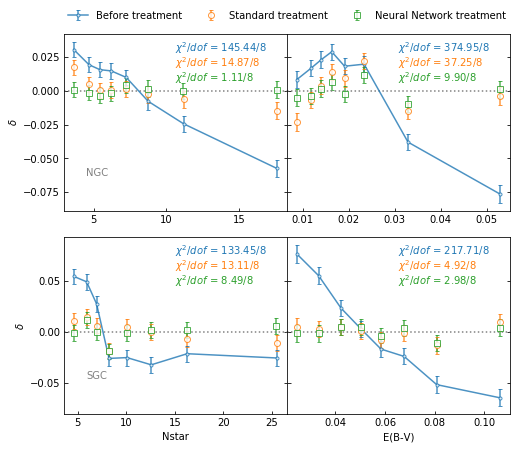

In [17]:
plot_overdensity('aaa')